In [1]:
%load_ext autoreload
%autoreload 2
import eval_models
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
X_art,y_art,X_dig,y_dig= eval_models.get_data()
X_art_train,X_art_test,y_art_train,y_art_test=train_test_split(X_art,y_art,stratify=y_art,test_size=0.25)

## No standarization at all

In [3]:
RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_art_train.values,y_art_train)
X_art_train_boruta=X_art_train.iloc[:,feat_select.support_]
X_art_test_boruta=X_art_test.iloc[:,feat_select.support_]

In [4]:
noscaling_res=eval_models.get_models_ba(X_art_train_boruta,
                              X_art_test_boruta,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.598
RandomForestClassifier 0.872
AdaBoostClassifier 0.632
LGBMClassifier 0.868
XGBClassifier 0.864
20  features in the dataset


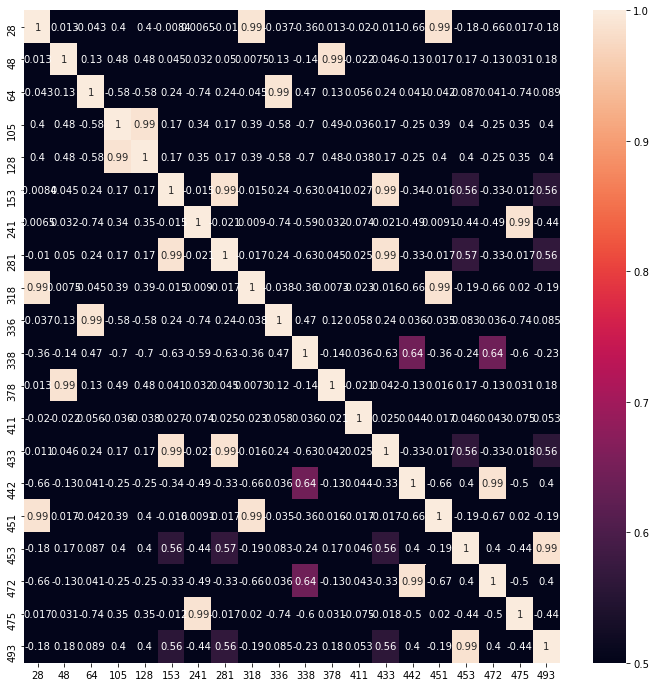

In [5]:
plt.figure(figsize=(12,12))
corr = X_art_train_boruta.corr()
sns.heatmap(corr,annot=True,vmin=0.5,vmax=1)
plt.show()

In [6]:
X_train_no_corr=eval_models.delete_corr(X_art_train_boruta)

In [7]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr,
                              X_art_test_boruta,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.606
RandomForestClassifier 0.864
AdaBoostClassifier 0.632
LGBMClassifier 0.848
XGBClassifier 0.862
10  features in the dataset


## Standarization after Boruta (not really expecting it to work)

In [8]:
X_art_train_boruta_sc,X_art_test_boruta_sc=eval_models.standarize(X_art_train_boruta,X_art_test_boruta)

In [9]:
X_train_no_corr2=eval_models.delete_corr(X_art_train_boruta_sc)

In [10]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr2,
                              X_art_test_boruta_sc,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.602
RandomForestClassifier 0.868
AdaBoostClassifier 0.634
LGBMClassifier 0.85
XGBClassifier 0.862
10  features in the dataset


## Standarization before Boruta

In [11]:
X_art_train_sc,X_art_test_sc=eval_models.standarize(X_art_train,X_art_test)

In [12]:
### (suggested max_depth between 3 and 7) podobno
RF = RandomForestClassifier(n_jobs=-1, max_depth=7)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_art_train_sc.values,y_art_train)
X_art_train_sc_boruta=X_art_train_sc.iloc[:,feat_select.support_]
X_art_test_sc_boruta=X_art_test_sc.iloc[:,feat_select.support_]

In [13]:
scaled_res=eval_models.get_models_ba(X_art_train_sc_boruta,
                              X_art_test_sc_boruta,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.614
RandomForestClassifier 0.868
AdaBoostClassifier 0.628
LGBMClassifier 0.86
XGBClassifier 0.858
21  features in the dataset


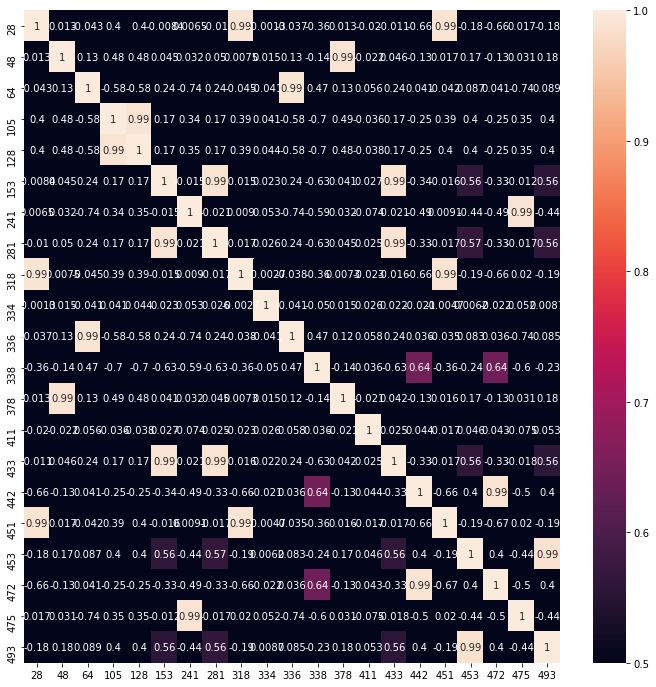

In [14]:
plt.figure(figsize=(12,12))
corr = X_art_train_sc_boruta.corr()
sns.heatmap(corr,annot=True,vmin=0.5,vmax=1)
plt.show()

In [15]:
X_art_train_sc_no_corr=eval_models.delete_corr(X_art_train_sc_boruta)

In [16]:
scaled_res_cor=eval_models.get_models_ba(X_art_train_sc_no_corr,
                              X_art_test_sc_boruta,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.6
RandomForestClassifier 0.858
AdaBoostClassifier 0.63
LGBMClassifier 0.864
XGBClassifier 0.854
11  features in the dataset


## Cross validation (with standarization before Boruta)

In [3]:
kf = KFold(n_splits=5,shuffle=True)
models_res=[]
for train_idx, val_idx in tqdm(kf.split(X_art_train)):
    X_train=X_art_train.iloc[train_idx,:]
    X_val=X_art_train.iloc[val_idx,:]
    y_train=y_art_train[train_idx]
    y_val=y_art_train[val_idx]
    
    X_train_sc,X_val_sc=eval_models.standarize(X_train,X_val)
    
    RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
    feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
    feat_select.fit(X_train.values,y_train)
    
    X_train_sc_boruta=X_train_sc.iloc[:,feat_select.support_]
    X_val_sc_boruta=X_val_sc.iloc[:,feat_select.support_]
    

    with open('../data/boruta/artificial-features.csv', 'a') as f:
        np.savetxt(f, np.where(feat_select.support_), delimiter=",", fmt='%i')
    f.close()
    X_train_sc_boruta_no_corr=eval_models.delete_corr(X_train_sc_boruta)
    tmp=eval_models.get_models_ba(X_train_sc_boruta_no_corr,X_val_sc_boruta,y_train,y_val)
    models_res.append(tmp)

0it [00:00, ?it/s]

LogisticRegression 0.5961
RandomForestClassifier 0.8908
AdaBoostClassifier 0.5813
LGBMClassifier 0.8794


1it [00:56, 56.73s/it]

XGBClassifier 0.8832
10  features in the dataset
LogisticRegression 0.5831
RandomForestClassifier 0.8667
AdaBoostClassifier 0.61
LGBMClassifier 0.8635


2it [01:50, 54.70s/it]

XGBClassifier 0.8368
9  features in the dataset
LogisticRegression 0.6232
RandomForestClassifier 0.8465
AdaBoostClassifier 0.6735
LGBMClassifier 0.8433


3it [02:47, 55.81s/it]

XGBClassifier 0.8433
10  features in the dataset
LogisticRegression 0.603
RandomForestClassifier 0.8523
AdaBoostClassifier 0.6311
LGBMClassifier 0.8431


4it [03:46, 57.30s/it]

XGBClassifier 0.8402
10  features in the dataset
LogisticRegression 0.6113
RandomForestClassifier 0.8515
AdaBoostClassifier 0.6644
LGBMClassifier 0.8582


5it [04:48, 57.70s/it]

XGBClassifier 0.8576
9  features in the dataset


In conclusion we could expect sth around 0.84 balanced accuracy score with 10 features.
We could use some other method to select only the 5 best ones. Nie wiem czy jest sens bo użycie 10 zamiast 5 to kara na poziomie 1 punktu procentowego